# 이론
#### 로지스틱 회귀
두 개의 클래스에 대해 분류하는 문제 형태를 **이진 분류**라고 한다.   
반면 세개 이상의 클래스에 대해 분류하는 문제 형태는 **다중 클래스**분류라고 한다.   
로지스틱 회귀는 선형 회귀를 이진 분류에 맞게끔 수정한 것이며, 이름은 회귀지만 분류에 더 많이 사용된다.   
H(x) = Wx + b의 형태의 가설로는 분류가 어려울 수 있다. 직선을 구부려서 55이하는 0, 60이상은 1로 표현하는 함수 f가 필요하게된다.   
선형회귀와 같이 W, b를 사용하고 최종 가설의 형태는 H(x) = f(Wx + b)의 형태가 된다.   
##### 시그모이드 함수
앞선 예시의 조건을 충족하는 함수의 일종으로, 결과값은 [0, 1]의 범위를 가지며 S자 곡선형태로 단조증가한다.   
-로 갈수록 0에 가까워지며, +로 갈수록 1에 가까워진다.    
W가 커질수록 그래프의 곡률이 커지며, b가 양수면 왼쪽, 음수면 오른쪽으로 그래프가 이동한다.   
이러한 시그모이드 함수를 사용한 로지스틱 회귀는 결과값을 0부터 1사이의 값을 출력하게 된다.   
기본적으로 0.5를 임계점(Threshold) 삼아 구분을 하게 된다.   
##### CE loss
분류에서 자주 사용하는 손실함수는 **cross entropy (CE) loss**라고 불리는 함수이다.   
#### 구현

In [3]:
import torch.nn as nn

class LogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(2, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear(x))

In [4]:
import torch
import torch.nn.functional as F

x_train = torch.FloatTensor([[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]])
y_train = torch.FloatTensor([[0], [0], [0], [1], [1], [1]])

model = LogisticRegression()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  prediction = model(x_train)
  cost = F.binary_cross_entropy(prediction, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    predicted_class = prediction >= torch.FloatTensor([0.5])
    correct_prediction = predicted_class.float() == y_train
    accuracy = correct_prediction.sum().item() / len(correct_prediction)
    print('Epoch {:4d} Cost: {:6.6f} Accuracy: {:2.2f}%'.format(
      epoch, cost.item(), accuracy * 100
    ))

Epoch    0 Cost: 0.565443 Accuracy: 66.67%
Epoch  100 Cost: 0.404199 Accuracy: 83.33%
Epoch  200 Cost: 0.342915 Accuracy: 83.33%
Epoch  300 Cost: 0.296183 Accuracy: 83.33%
Epoch  400 Cost: 0.259488 Accuracy: 83.33%
Epoch  500 Cost: 0.230277 Accuracy: 100.00%
Epoch  600 Cost: 0.206676 Accuracy: 100.00%
Epoch  700 Cost: 0.187318 Accuracy: 100.00%
Epoch  800 Cost: 0.171212 Accuracy: 100.00%
Epoch  900 Cost: 0.157634 Accuracy: 100.00%
Epoch 1000 Cost: 0.146050 Accuracy: 100.00%


#### 소프트맥스 회귀
앞서 로지스틱 회귀에서는 클래스가 2개인 이진 분류를 수행했지만 3개 이상의 클래스에 대해 분류하는 경우를 가정한다.
- 꽃받침의 길이, 넓이, 꽃잎 길이, 넓이라는 4가지 특징으로 setosa, versicolor, virginica 중 어떤 붓꽃인지 알고싶은 상황   

소프트맥스는 n개 값을 갖는 임의의 벡터를 **합계 가능한 확률값 분포**로 바꾸어준다.   
1. 소프트맥스 함수의 입력으로 어떻게 바꿀까?
2. 오차를 어떻게 구할까?   

를 고민해야한다.   
4개의 feature로부터 3개의 값을 갖는 소프트맥스 함수의 입력으로 바꾸기 위해 행렬 연산을 수행. 이 때 행렬곱에 사용되는 W와 행렬합에 사용되는 B가 존재한다.   

##### one-hot encoding
오차를 구하기 위해 **소프트맥스 결과값과 같은 차원**의 레이블 정보를 생성한다.   
- 해당 클래스는 확률1, 나머지는 0으로 만든 이러한 벡터 생성 방식을 원-핫 인코딩이라고 한다.
- virginica의 원-핫 벡터: [1, 0, 0]
- setosa의 원-핫 벡터: [0, 1, 0]
- versicolor의 원-핫 벡터: [0, 0, 1]

오차를 구하기 위한 손실 함수로는 CE 함수를 활용한다. **해당 클래스임을 예측하는 확률에 대한 로그 함수값에 -1을 곱**한 것이 오차값이 되므로, 1에 가깝게 예측할수록 손실값이 0에 가깝고, 0에 가깝게 예측할수록 손실값이 무한대에 가까워진다.
#### 구현
소프트맥스 회귀 모델은 토치에서 손실값 계산 시 자동으로 softmax 연산까지 수행하므로 **일반적으로 모델 코드에서 softmax를 생략하고 사용**한다.   
다른 말로하면 예측값 생성 및 출력 시에는 별도의 softmax 연산이 필요하다.

In [5]:
import torch
import torch.nn as nn

class SoftmaxRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(4, 3)
    #토치의 cross_entropy class는 손실값 계산 시의 softmax 연산까지 포함되어 있음.
  def forward(self, x):
    return self.linear(x)

##### 학습 코드(데이터셋 및 모델 생성)
토치에서 softmax 기반 분류를 수행할 때는 **레이블 정보를 long type의 1D 텐서로 입력**해야한다.   
손실 값 계산 시의 **one-hot vector** 생성은 내부적으로 자동수행된다.

In [6]:
x_train = torch.FloatTensor([[6.3, 3.3, 6.0, 2.5],
                             [5.8, 2.7, 5.1, 1.9],
                             [7.1, 3.0, 5.9, 2.1],
                             [5.1, 3.5, 1.4, 0.2],
                             [4.9, 3.0, 1.4, 0.2],
                             [4.7, 3.2, 1.3, 0.2],
                             [7.0, 3.2, 4.7, 1.4],
                             [6.4, 3.2, 4.5, 1.5],
                             [6.9, 3.1, 4.9, 1.5]])
y_train = torch.LongTensor([0, 0, 0, 1, 1, 1, 2, 2, 2])
# Class 0: virginica, Class 1: setosa, Class 2: versicolor

model = SoftmaxRegression()

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  prediction = model(x_train)
  cost = F.cross_entropy(prediction, y_train)
  
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    correct_prediction = torch.argmax(prediction, 1) == y_train
    #argmax를 dim 1에 대해 수행하면 각각 데이터의 예측값에서 가장 큰 값의 인덱스가 반환된다.
    accuracy = correct_prediction.float().mean().item()
    print('Epoch {:4d}/{} Cost: {:6.6f} Accuracy: {:2.2f}%'.format(
      epoch, nb_epochs, cost.item(), accuracy * 100
    ))

Epoch    0/1000 Cost: 3.066065 Accuracy: 33.33%
Epoch  100/1000 Cost: 0.228220 Accuracy: 100.00%
Epoch  200/1000 Cost: 0.150005 Accuracy: 100.00%
Epoch  300/1000 Cost: 0.112255 Accuracy: 100.00%
Epoch  400/1000 Cost: 0.089540 Accuracy: 100.00%
Epoch  500/1000 Cost: 0.074392 Accuracy: 100.00%
Epoch  600/1000 Cost: 0.063585 Accuracy: 100.00%
Epoch  700/1000 Cost: 0.055494 Accuracy: 100.00%
Epoch  800/1000 Cost: 0.049216 Accuracy: 100.00%
Epoch  900/1000 Cost: 0.044205 Accuracy: 100.00%
Epoch 1000/1000 Cost: 0.040115 Accuracy: 100.00%


#### mini batch
- 지금까지 다룬 경사하강법 방식은 **데이터셋 전체에 대해 한번에** 예측값 계산 > 손실값 계산 > 미분값 계산 > 업데이트를 수행하였다.
  - 이와 같이 전체 데이터를 한번에 사용하는 경사하강법을 **배치 경사하강법**이라 하며 배치는 전체 데이터 묶음을 의미한다.
- 데이터셋이 커지면 이를 여러 조각으로 나누어 경사하강법을 수행하게 되고 이를 **미니 배치 경사하강법**이라 한다.
  - 이 때, 경사하강법을 수행하는 작은 데이터 묶음을 **미니 배치**라고 한다.
  - 이 미니 배치의 크기를 **배치 크기**라고 한다.
#### iteration and epoch
- 데이터셋 전체에 모두 경사하강법을 수행하는 단위를 에포크라고 한다.
- **경사하강법을 수행하는 각 횟수를 이터레이션**이라고 한다.
  - 예를 들어 배치 경사하강법에서는 1이터레이션 == 1에포크이다.
  - 미니배치에서는 특정 횟수의 이터레이션이 쌓여야 1에포크가 된다.
#### data set and data loader
- 토치에서는 미니배치를 위해 데이터로더라는 클래스를 제공한다.
  - 미니 배치를 하나씩 반환해주는 iterator라고 보자.
- 데이터로더 활용을 위해서는 데이터셋 객체가 필요하며 이는 다양하게 생성 가능하다.
#### 구현
소프트맥스 회귀를 이용해 MNIST 데이터를 분류한다.   
이미지 데이터를 1차원으로 변환한 크기 784에서 10개의 클래스에 대한 결과를 도출한다.

In [8]:
class MNIST_SoftmaxRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(784, 10)

  def forward(self, x):
    return self.linear(x)

총 에포크, 배치 크기 등 학습에 영향을 끼치며 사람이 직접 지정하는 변수들을 **하이퍼파라미터**라고 한다.   

In [9]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

#hyperparameters
training_epochs = 15
batch_size = 100

#MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                           train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

딥러닝 모델의 경우 학습 루프 내 매번 F.cross_entropy를 이용해 손실값을 계산치 않고, nn.CrossEntropyLoss를 이용해 손실값을 계산할 객체를 미리 만들어두는 형식을 널리 사용한다.

In [10]:
#dataset loader
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

model = MNIST_SoftmaxRegression()
criterion = nn.CrossEntropyLoss() # CE loss 계산을 위한 객체 미리 만듦.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

MNIST 데이터셋의 경우 데이터 및 레이블 두 종류의 텐서가 합쳐져 있는 형태이므로 데이터로더에서 **(데이터, 레이블) 형태의 튜플**로 값을 넘겨준다.

In [ ]:
print("W: ", list(model.parameters())[0].shape, "B: ", list(model.parameters())[1].shape)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for idx, (x_train, y_train) in enumerate(data_loader):
    print("Original: ", x_train.shape)
    x_train = x_train.view(-1, 28 * 28)
    print("Reshaped: ", x_train.shape)
    
    pred = model(x_train)
    print("Result: ", pred.shape)
    cost = criterion(pred, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

보다 큰 데이터셋에 경우 테스트에서도 미니 배치를 활용해 정확도를 계산하고 통계를 산출한다.

In [12]:
with torch.no_grad(): #gradient 계산을 수행하지 않음.
  x_test = mnist_test.data.view(-1, 28 * 28).float()
  y_test = mnist_test.targets

  prediction = model(x_test)
  correct_prediction = torch.argmax(prediction, 1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.8837000131607056


Label:  8
Prediction:  8


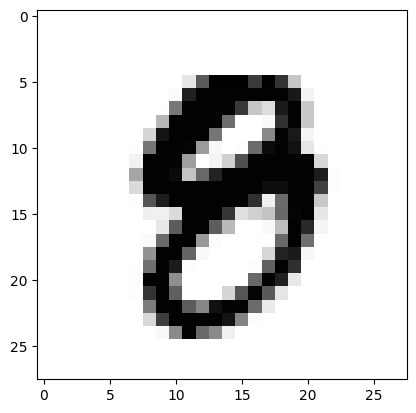

In [13]:
with torch.no_grad():
  r = random.randint(0, len(mnist_test) - 1)
  x_single_data = mnist_test.data[r:r + 1].view(-1, 28 * 28).float()
  y_single_data = mnist_test.targets[r:r + 1]

  print('Label: ', y_single_data.item())
  single_prediction = model(x_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()